In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import  silhouette_score
from sklearn import preprocessing as preproc
import random
import string
import math
import time

In [19]:
class Chromosome:
    
    def __init__(self, genetic_code, fitness):
        self.genetic_code = genetic_code
        self.fitness = fitness
    
    def labels(self):
        return " ".join(map(lambda x: str(x), self.genetic_code))
        
    def __str__(self):
        return self.labels()

In [20]:
generation_sizes = [20, 40]             
reproduction_sizes = [10]              
max_iterations = [25,50]              
mutation_rates = [0.1,0.15,0.2]             
tournament_sizes = [5]             
selection_types = ['tournament','roulette']    
distance_types = ['manhattan','cosine','euclid']   
crossover_points = [1,2]
preprocessing = [True,False]

In [21]:
best_silhouette_score = float('-inf')
silhouette_scores = []
best_params = {}
best_clusters = []
cluster_num = int(input("Cluster number:"))

Cluster number: 3


In [22]:
def refresh_best_params_and_clusters(generation_size,reproduction_size,
                        max_iterations, mutation_rate, tournament_size,
                        selection_type, distance_type, crossover_points,
                        preprocessing,clusters):
    best_params = {
        "generation_size" :  generation_size,      
        "reproduction_size" : reproduction_size,  
        "max_iterations" : max_iterations,              
        "mutation_rate" : mutation_rate,             
        "tournament_size" : tournament_size,                     
        "selection_type" : selection_type,    
        "distance_type" : distance_type,
        "crossover_points" : crossover_points,
        "preprocessing" : preprocessing
    }
    best_clusters = clusters
    
    return (best_params,clusters)

In [110]:
class GeneticAlgorithm:

    def __init__(self, data, generation_size,reproduction_size,
                max_iterations, mutation_rate, tournament_size,
                selection_type, distance_type, crossover_points,
                preprocessing, sa_usage=False, sa_rate=0.3, sa_max_iter=0.1):
                
        self.generation_size =  generation_size            
        self.reproduction_size = reproduction_size  
        self.max_iterations = max_iterations              
        self.mutation_rate = mutation_rate             
        self.tournament_size = tournament_size                     
        self.selection_type = selection_type    
        self.distance_type = distance_type
        self.crossover_points = crossover_points
        self.preprocessing = preprocessing
        self.sa_usage = sa_usage
        self.sa_rate = sa_rate
        self.sa_max_iter = math.ceil(sa_max_iter*data.shape[0])
        #---------------------------------------------------------
        if(self.preprocessing):
            scaler = preproc.StandardScaler().fit(data)
            data = pd.DataFrame(scaler.transform(data))
            data.rename(columns={data.columns[0]: 'height', data.columns[1]: 'weight'}, inplace=True)
            
        self.data = data

        #unos broja klastera
        self.cluster_num = cluster_num
        
        #broj instanci
        self.row_num = data.shape[0]
        #---------------------------------------------------------
        
    
    def distance(self, i1 ,i2, distType):
        
        if distType == 'euclid':
            #Euclid                
            squared_coord_diff_sum = 0    
            for field in i1._fields:        
                if field == "Index" or field == "Clusters":
                    continue            
                else:
                    squared_coord_diff = (getattr(i1, field) - getattr(i2, field))**2
                    squared_coord_diff_sum = squared_coord_diff_sum + squared_coord_diff    
            distance = math.sqrt(squared_coord_diff_sum)                        
            return distance
        
        elif distType == 'manhattan':
            #manhattan distance
            total = 0
            for field in i1._fields:        
                if field == "Index" or field == "Clusters":
                    continue            
                else:
                    total  += abs(getattr(i1, field) - getattr(i2, field))
                                
            return total
        
        elif distType == 'cosine':
            #cosine distance
            total = 0
            
            up = 0
            down_1 = 0
            down_2 = 0
            
            for field in i1._fields:        
                if field == "Index" or field == "Clusters":
                    continue            
                else:
                    a = getattr(i1, field)
                    a_sq = a ** 2
                    b = getattr(i2, field)
                    b_sq = b ** 2
                    
                    up += a * b
                    
                    down_1 += a_sq
                    down_2 += b_sq
                                
            return up / (math.sqrt(down_1) * math.sqrt(down_2))
        
        
    def calculateSum(self, data, cluster_num):
        
        sum = 0    
        for cl in range(0,cluster_num):

            cluster_data = data.loc[data["Cluster"] == cl]        
            cluster_sum = 0

            #distanca medju instancama u jednom klasteru
            #iteriramo kroz parove redova u klasteru sa poretkom da ne bismo ponavljali parove
            for namedTuple1 in cluster_data.itertuples():
                for namedTuple2 in cluster_data.itertuples():
                    if(namedTuple1[0] < namedTuple2[0]):
                        cluster_sum = cluster_sum + self.distance(namedTuple1, namedTuple2, self.distance_type)

            sum = sum + cluster_sum    

        return sum
    
    
    def calculate_fitness(self, genetic_code):        
        
        np_clusters = np.array(genetic_code)
        self.data["Cluster"] = np_clusters
        fitness_value = self.calculateSum(self.data, self.cluster_num)
        
        return fitness_value            
    
    
    def initial_population(self):
        
        init_population = []
        
        for i in range(self.generation_size):
            # generise se i-ti nasumicni genetski kod
            genetic_code = []
            
            for j in range(self.row_num):
                # za svaki red u podacima bira se nasumicno klaster
                selected_value = random.choice(range(self.cluster_num))
                genetic_code.append(selected_value)
            
            # izracunava se prilagodjenost hromozoma
            fitness = self.calculate_fitness(genetic_code)
            new_chromosome = Chromosome(genetic_code, fitness)
            
            # dodaje se u populaciju
            init_population.append(new_chromosome)
            
        return init_population
    
    
    def selection(self, chromosomes):
        
        selected = []
        
        # Bira se self.reproduction_size hromozoma za reprodukciju
        # Selekcija moze biti ruletska ili turnirska
        for i in range(self.reproduction_size):
            if self.selection_type == 'roulette':
                selected.append(self.roulette_selection(chromosomes))
            elif self.selection_type == 'tournament':
                selected.append(self.tournament_selection(chromosomes))
          
        # Vracaju se izabrani hromozomi za repodukciju
        return selected
    
    
    def roulette_selection(self, chromosomes):
        
        # suma svih prilagodjenosti
        total_fitness = sum([chromosome.fitness for chromosome in chromosomes])
            
        
        # bira se neka random vrednost, sluzi za 'imitiranje' slucajnosti 
        selected_value = random.randrange(0, math.ceil(total_fitness))
        
        current_sum = 0
        for i in range(self.generation_size):
            current_sum += chromosomes[i].fitness

            # vraca se prva jedinka koja ispuni uslov
            if current_sum > selected_value:
                return chromosomes[i]
     
    def tournament_selection(self, chromosomes):
        
        # bira se  self.tournament_size jediniki za turnir
        selected = random.sample(chromosomes, self.tournament_size)
        
        # pobednik je onaj sa najboljom prilagodjenosti
        winner = min(selected, key = lambda x: x.fitness)
        
        return winner
    
    
    def mutate(self, genetic_code):
        
        random_value = random.random()
        
        # ukoliko je ispunjen uslov, izvrsi mutaciju
        if random_value < self.mutation_rate:
            
            # izabrati proizvoljan indeks
            random_index = random.randrange(self.row_num)
            
            while True:
                # izabrati novu proizvoljnu vrednost za klaster
                new_cluster_value = random.choice(range(self.cluster_num))
                
                # ukoliko su vrednosti razlicite, izmeni klaster
                if genetic_code[random_index] != new_cluster_value:
                    break
                    
            genetic_code[random_index] = new_cluster_value
            
        return genetic_code
    
    
    def simulated_annealing(self, chromosomes):
        
        #print("usao u sa ", len(chromosomes))
        
        #nad odabranim jedinkama radimo simulirano kaljenje
        for ch in chromosomes:
            for i in range(0, self.sa_max_iter):
                
                #nausmicno biramo indeks
                random_index = random.randrange(self.row_num)
                
                #nasumicno biramo novu vrednost
                while True:
                    new_cluster_value = random.choice(range(self.cluster_num))
                    if ch.genetic_code[random_index] != new_cluster_value:
                        break
                        
                #pamtimo staru vrednost i postavljano novu
                old_cluster_value = ch.genetic_code[random_index]
                ch.genetic_code[random_index] = new_cluster_value
                
                #racunamo novu vrednost f-je prilagodjenosti
                new_fitness = self.calculate_fitness(ch.genetic_code)
                
                if new_fitness < ch.fitness:
                    #ako je bolja pamtimo je
                    ch.fitness = new_fitness
                else:
                    #ako nije bolja pamtimo je sa nekom verovatnocom, u suprotnom vracamo na staru vrednost
                    p = 1.0 / (i + 1) ** 0.5
                    q = random.uniform(0, 1)
                    if p > q:
                        ch.fitness = new_fitness
                    else:
                        ch.genetic_code[random_index] = old_cluster_value
        
        
    def create_generation(self, chromosomes):
        
        generation = []
        generation_size = 0
        
        while generation_size < self.generation_size:
            
            # Proizvoljno se biraju 2 roditelja za ukrstanje
            [parent1, parent2] = random.sample(chromosomes, 2)
            
            # Dobijaju se 2 detata ukrstanjem
            child1_code, child2_code = self.crossover(parent1, parent2)
            
            # Vrsi se mutacija nad decom
            child1_code = self.mutate(child1_code)
            child2_code = self.mutate(child2_code)
            
            # Prave se novi hromozomi
            child1 = Chromosome(child1_code, self.calculate_fitness(child1_code))
            child2 = Chromosome(child2_code, self.calculate_fitness(child2_code))
            
            # Dodaju se u generaciju
            generation.append(child1)
            generation.append(child2)
            
            generation_size += 2
        
        if self.sa_usage:
            #odaberi jedinke za simulirano klajenje 
            num_of_chromosomes_for_sa = math.floor(self.sa_rate*self.generation_size)
            chromosomes_for_sa = random.sample(generation, num_of_chromosomes_for_sa)

            #uradi simulirano kaljenje
            self.simulated_annealing(chromosomes_for_sa)  
        
        return generation
            
    
    def crossover(self, parent1, parent2):
        if self.crossover_points == 2:
            tmp = random.sample(range(1,  self.row_num), 2)
            tmp.sort()
            point1 = tmp[0]
            point2 = tmp[1]
            child1 = parent1.genetic_code[:point1] + parent2.genetic_code[point1:point2] + parent1.genetic_code[point2:]
            child2 = parent2.genetic_code[:point1] + parent1.genetic_code[point1:point2] + parent2.genetic_code[point2:]
            
            
            return (child1, child2)
            
        else:
            # bira se proizvoljna tacka ukrstanja
            break_point = random.randrange(1, self.row_num)

            child1 = parent1.genetic_code[:break_point] + parent2.genetic_code[break_point:]
            child2 = parent2.genetic_code[:break_point] + parent1.genetic_code[break_point:]
            return (child1, child2)
        

    def optimize(self):
        
        # Generisi pocetnu populaciju jedinki i izracunaj
        # prilagodjenost svake jedinke u populaciji
        population = self.initial_population()
        
        for i in range(0, self.max_iterations):
            
            # Selekcija 
            selected = self.selection(population)
            
            # Kreiraj generaciju ukrstanjem i mutacijom
            population = self.create_generation(selected)
            
            # Najkvalitetnija jedinka
            global_best_chromosome = min(population, key=lambda x: x.fitness)
        
        self.data["Cluster"] = global_best_chromosome.genetic_code
            
        return global_best_chromosome

In [116]:
"""
data_dogs = pd.read_csv("./dogs.csv")
data_dogs = data_dogs.drop(columns='breed')

genetic_algorithm = GeneticAlgorithm(data=data_dogs, generation_size=40, reproduction_size=10,
    max_iterations=50, mutation_rate=0.15, tournament_size=5, selection_type='tournament', distance_type='euclid', 
                    crossover_points=2, preprocessing=False, sa_usage=True)

result = genetic_algorithm.optimize()
print(genetic_algorithm.data)


figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(genetic_algorithm.data['height'].tolist(), genetic_algorithm.data['weight'].tolist(), c = list(genetic_algorithm.data['Cluster']))
"""

'\ndata_dogs = pd.read_csv("./dogs.csv")\ndata_dogs = data_dogs.drop(columns=\'breed\')\n\ngenetic_algorithm = GeneticAlgorithm(data=data_dogs, generation_size=40, reproduction_size=10,\n    max_iterations=50, mutation_rate=0.15, tournament_size=5, selection_type=\'tournament\', distance_type=\'euclid\', \n                    crossover_points=2, preprocessing=False, sa_usage=True)\n\nresult = genetic_algorithm.optimize()\nprint(genetic_algorithm.data)\n\n\nfigure = plt.figure()\nfigure.add_subplot(1,1,1)\nplt.scatter(genetic_algorithm.data[\'height\'].tolist(), genetic_algorithm.data[\'weight\'].tolist(), c = list(genetic_algorithm.data[\'Cluster\']))\n'

Kraj, uradjeno  284
Najbolji parametri:
generation_size :  40
reproduction_size :  10
max_iterations :  50
mutation_rate :  0.15
tournament_size :  5
selection_type :  tournament
distance_type :  euclid
crossover_points :  2
preprocessing :  True
Najbolja silueta:  0.7517307195488381
Proteklo vreme:  1956.0625


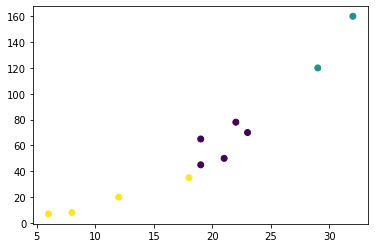

In [25]:
data = pd.read_csv("./dogs.csv")
data = data.drop(columns='breed')
row_num = data.shape[0]
i = 0

start_time = time.process_time()

for generation_size in generation_sizes:
    for reproduction_size in reproduction_sizes:
        for max_iteration in max_iterations:
            for mutation_rate in mutation_rates:
                for tournament_size in tournament_sizes:
                    for selection_type in selection_types:
                        for distance_type in distance_types:
                            for crossover_point in crossover_points:
                                for prep in preprocessing:
                                    
                                    genetic_algorithm = GeneticAlgorithm(data,generation_size,reproduction_size,
                                        max_iteration, mutation_rate, tournament_size,
                                        selection_type, distance_type, crossover_point,
                                        prep)
                                    result = genetic_algorithm.optimize()


                                    #print(f"{i}")
                                    i+=1
                                    np_clusters = np.array(result.genetic_code)
                                    data_cp = genetic_algorithm.data

                                    resulting_num_of_clusters = np.unique(np_clusters).size

                                    #ovakva klasterovanja preskacemo da ne bi doslo do greske pri racunanju siluete
                                    if resulting_num_of_clusters == 1 or resulting_num_of_clusters == row_num:
                                        continue

                                    silhouette = silhouette_score(data_cp, np_clusters)

                                    silhouette_scores.append(silhouette)

                                    if silhouette > best_silhouette_score:
                                        (best_params,best_clusters) = refresh_best_params_and_clusters(
                                                                     genetic_algorithm.generation_size,
                                                                     genetic_algorithm.reproduction_size,
                                                                     genetic_algorithm.max_iterations,
                                                                     genetic_algorithm.mutation_rate,
                                                                     genetic_algorithm.tournament_size,
                                                                     genetic_algorithm.selection_type,
                                                                     genetic_algorithm.distance_type,
                                                                     genetic_algorithm.crossover_points,
                                                                     genetic_algorithm.preprocessing,
                                                                     np_clusters)
                                        best_silhouette_score = silhouette
end_time = time.process_time()

print("Kraj, uradjeno ", len(silhouette_scores))

data["Cluster"] = best_clusters

print("Najbolji parametri:")
for (k,v) in best_params.items():
    print(str(k), ": ", str(v))
print("Najbolja silueta: ", best_silhouette_score)
print("Proteklo vreme: ", end_time - start_time)

figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(genetic_algorithm.data['height'].tolist(), genetic_algorithm.data['weight'].tolist(), c = list(genetic_algorithm.data['Cluster']))


In [27]:
x = [i for i in range(0,284)]
plt.plot(x,silhouette_scores)

In [75]:
genetic_algorithm = GeneticAlgorithm(data, best_params["generation_size"], best_params["reproduction_size"],
    best_params["max_iterations"], best_params["mutation_rate"], best_params["tournament_size"],
    best_params["selection_type"], best_params["distance_type"], best_params["crossover_points"],
    False)

start_time = time.process_time()
result = genetic_algorithm.optimize()
end_time = time.process_time()

In [76]:
print("Vreme izvrsavanja: ", end_time - start_time)
print("Suma: ", result.fitness)

Vreme izvrsavanja:  11.890625
Suma:  319.6229092201534


In [77]:
#racunamo siluetu
siluette = silhouette_score(genetic_algorithm.data.drop(columns='Cluster'), result.genetic_code)
print("Silueta: ", siluette)

Silueta:  0.5423733549698899


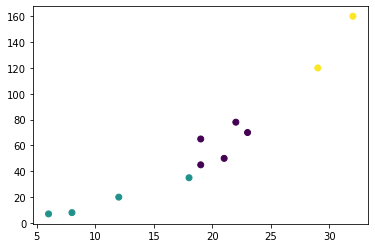

In [78]:
figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(genetic_algorithm.data['height'].tolist(), genetic_algorithm.data['weight'].tolist(), c = list(result.genetic_code))

In [117]:
genetic_algorithm = GeneticAlgorithm(data, best_params["generation_size"], best_params["reproduction_size"],
    best_params["max_iterations"], best_params["mutation_rate"], best_params["tournament_size"],
    best_params["selection_type"], best_params["distance_type"], best_params["crossover_points"],
    False, True)

start_time = time.process_time()
result = genetic_algorithm.optimize()
end_time = time.process_time()

In [118]:
print("Vreme izvrsavanja: ", end_time - start_time)
print("Suma: ", result.fitness)

Vreme izvrsavanja:  18.4375
Suma:  319.6229092201534


In [119]:
#racunamo siluetu
siluette = silhouette_score(genetic_algorithm.data.drop(columns='Cluster'), result.genetic_code)
print("Silueta: ", siluette)

Silueta:  0.5423733549698899


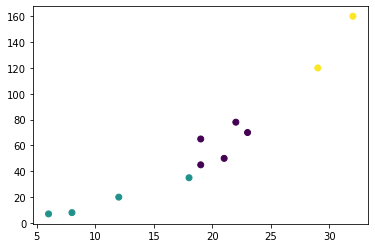

In [120]:
figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(genetic_algorithm.data['height'].tolist(), genetic_algorithm.data['weight'].tolist(), c = list(result.genetic_code))

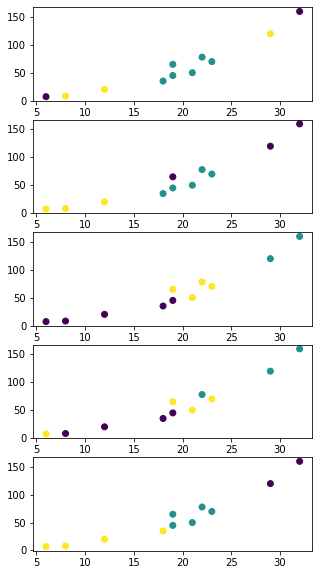

In [144]:
genetic_algorithm = GeneticAlgorithm(data, best_params["generation_size"], best_params["reproduction_size"],
    best_params["max_iterations"], best_params["mutation_rate"], best_params["tournament_size"],
    best_params["selection_type"], best_params["distance_type"], best_params["crossover_points"],
    False)

iters = [5,8,10,15,30]
rep_sizes = [2,3,5,6,10]

fig, ax = plt.subplots(5, figsize=(5, 10))

for i in range(0,5):
    genetic_algorithm.max_iterations = iters[i]
    genetic_algorithm.reproduction_size = rep_sizes[i]
    
    result = genetic_algorithm.optimize()
    
    ax[i].scatter(genetic_algorithm.data['height'].tolist(), genetic_algorithm.data['weight'].tolist(), c = list(result.genetic_code))